# Assignment 05
#### Collaborators: Mauricio Bermudez, Alvaro Montoya Ruiz, Hriday Reddy Purma
#### Task: Image Classification. Training and validation runs registry.

# Introduction

This document demonstrates how to build and train a simple neural network using PyTorch for binary classification on a synthetic spiral dataset. We integrate Weights & Biases (wandb) to record training metrics (F1 score, recall, precision) along with the network’s weights, biases, and gradients during training. A random sweep is conducted over four hyperparameters—hidden units per layer, learning rate, dropout percentage, and batch size—with four candidate values each. Out of all possible combinations, 12 random samples will be chosen for the sweep. In addition, this notebook is updated to run on CUDA (GPU) if available, or on the CPU otherwise.

# 1. Importing Libraries and Setting the Device

We begin by importing libraries for numerical computations, plotting, neural network modeling with PyTorch, evaluation metrics, and wandb for experiment tracking. We then set the device based on CUDA availability.

In [2]:
import torch
import os
import wandb
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,random_split
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score


# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

# set repeatability
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)     # Set a random seed for CUDA operations.
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    
    # Ensure deterministic behavior for CUDA operations (note: If you are not concerned with reportable reproducibility, set deterministic to false, and benchmark to true - as it can choose faster algorithms).
    torch.backends.cudnn.deterministic = True  # Set cuDNN to deterministic mode - it will now only select algorithms that are known to be deterministic.
    torch.backends.cudnn.benchmark = False  # Disable cuDNN benchmarking - it may select the best algorithms for the hardware, but it doesn't guarantee deterministic results.   

Using device: cuda


In [3]:
# Load the API key from the environment variable
wandb_api_key = os.getenv("WANDB_API_KEY")
if wandb_api_key:
    wandb.login(key=wandb_api_key)
else:
    raise ValueError("WANDB_API_KEY environment variable not set!")
# Initialize wandb. The hyperparameters will be updated by the sweep.
wandb.init(project="Assignment5", entity="usf-magma", config={
    "num_classes": 120,        # default, will be overridden
    "learning_rate": 0.002,      # default, will be overridden
    "dropout_percentage": 0.35,  # default, will be overridden
    "batch_size": 64,           # default, will be overridden
    "epochs": 15,
    "momentum":(0.9, 0.92),
    "weight_decay": 1e-5 ,
    "optimizer": "Adam",
    "criterion": "CrossEntropyLoss",
})

wandb.run.save()
config = wandb.config

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\maurb\_netrc
wandb: Currently logged in as: bermudezm (usf-magma) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


## Dataset :
ArtBench-10 is a class-balanced, high-quality dataset comprising 60,000 images across 10 distinctive artistic styles, with 5,000 training images and 1,000 testing images per style. The dataset is designed for benchmarking artwork generation and is available in three resolutions: 32×32, 256×256, and original image size.


In [4]:
# Define transformations for training (with augmentation) and testing
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Random cropping
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Path to the dataset folder (organized by class)
dataset_dir = './StanfordDogs/images/Images'

# Load full dataset
full_dataset = ImageFolder(root=dataset_dir)

# Split dataset (80% train, 20% test)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Ensure reproducibility of the split
trainset, testset = random_split(full_dataset, [train_size, test_size])

# Apply specific transforms to train and test sets
trainset.dataset = ImageFolder(root=dataset_dir, transform=transform_train)
testset.dataset = ImageFolder(root=dataset_dir, transform=transform_test)

# Create DataLoaders
trainloader = DataLoader(trainset, batch_size=config.batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=config.batch_size, shuffle=False, num_workers=4)

# Get class names
classes = full_dataset.classes  # List of 120 dog breeds

# Log dataset info to W&B
wandb.config.update({
    "dataset": "Stanford Dogs",
    "num_classes": len(classes),
    "train_size": train_size,
    "test_size": test_size,

})

print(f"Dataset loaded with {len(classes)} classes.")
print(f"Training set size: {train_size}")
print(f"Test set size: {test_size}")

Dataset loaded with 120 classes.
Training set size: 16464
Test set size: 4116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


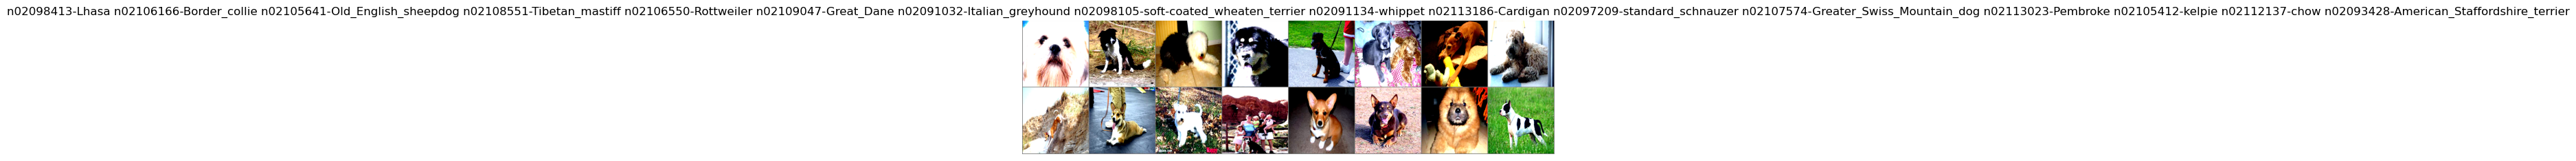

In [5]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get random training images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Create grid of images
img_grid = torchvision.utils.make_grid(images[:16])

# Show images
plt.figure(figsize=(10, 5))
imshow(img_grid)
plt.title(' '.join('%5s' % classes[labels[j]] for j in range(16)))
plt.show()

# Log images to W&B
wandb.log({"sample_predictions": [wandb.Image(images[i], caption=classes[labels[i]]) 
                            for i in range(16)]})

In [6]:
# Load pre-trained ResNet-50
model = torchvision.models.resnet50(weights='IMAGENET1K_V1')

# Print the original structure
print("Original model:")
print(model.fc)  # The final fully connected layer

# Modify the final layer for CIFAR-10 (10 classes)
num_features = model.fc.in_features  # Get the number of input features to the final layer
model.fc = nn.Linear(num_features, config.num_classes)  # Replace with a new layer for 10 classes

# Print the modified structure
print("\nModified model:")
print(model.fc)

# Move model to the device (GPU if available)
model = model.to(device)

# Log model information to W&B
wandb.config.update({
    "model": "ResNet-50",
    "pretrained": True,
    "input_features": num_features
})

# Setup W&B to track the model's parameters and gradients
wandb.watch(model, log="all", log_freq=100)

Original model:
Linear(in_features=2048, out_features=1000, bias=True)

Modified model:
Linear(in_features=2048, out_features=120, bias=True)


In [ ]:
# Freeze early layers
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.bn1.parameters():
    param.requires_grad = False
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False

# Unfreeze later layers
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# Unfreeze parameters of the final fully connected layer
# for param in model.fc.parameters():
#     param.requires_grad = True

# Count the number of trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of total)")

# Log to W&B
wandb.config.update({
    "trainable_params": trainable_params,
    "total_params": total_params,
    "approach": "feature_extraction"
})

Trainable parameters: 22,308,984 (93.92% of total)


In [8]:
# Create a folder for saving models
os.makedirs('saved_models', exist_ok=True)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=config.learning_rate)
#optimizer = torch.optim.Adam([
#    {'params': model.layer4.parameters(), 'lr': 1e-5},  # Capas descongeladas con LR bajo
#    {'params': model.fc.parameters(), 'lr': 1e-4}  # Capa totalmente conectada con LR mayor
#])

# Training loop
def train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=config.epochs):
    # Track best accuracy
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []
        
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Collect predictions and labels for F1 calculation
            all_train_preds.extend(predicted.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            # Log batch statistics (every 100 batches)
            if i % 100 == 99:
                batch_acc = 100. * correct / total
                batch_loss = running_loss / total
                print(f'Batch {i+1}, Loss: {batch_loss:.4f}, Acc: {batch_acc:.2f}%')
                
                wandb.log({
                    "train_batch_loss": batch_loss,
                    "train_batch_acc": batch_acc,
                    "epoch": epoch + i/len(trainloader)
                })
        
        # Calculate epoch statistics
        train_loss = running_loss / len(trainloader.dataset)
        train_acc = 100. * correct / total
        
        # Calculate F1 score for the training epoch
        train_f1_macro = f1_score(all_train_labels, all_train_preds, average='macro')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, F1-macro: {train_f1_macro:.4f}')
        
        # Evaluation phase
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        class_correct = list(0. for i in range(config.num_classes))
        class_total = list(0. for i in range(config.num_classes))
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Per-class accuracy
                c = (predicted == labels).squeeze()
                for i in range(labels.size(0)):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
                
                # Store for confusion matrix and F1 calculation
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate test statistics
        test_loss = test_loss / len(testloader.dataset)
        test_acc = 100. * correct / total
        
        # Calculate F1 score for test data
        test_f1_macro = f1_score(all_labels, all_preds, average='macro')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%, F1-macro: {test_f1_macro:.4f}')
        
        # Per-class accuracy
        for i in range(config.num_classes):
            class_acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
            #print(f'Accuracy of {classes[i]}: {class_acc:.2f}%')
        
        # Log epoch statistics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "train_f1_macro": train_f1_macro,
            "test_loss": test_loss,
            "test_acc": test_acc,
            "test_f1_macro": test_f1_macro
        })
        
        # Log per-class accuracy
        class_acc_dict = {f"class_acc_{classes[i]}": 100 * class_correct[i] / class_total[i] 
                         if class_total[i] > 0 else 0 for i in range(config.num_classes)}
        wandb.log(class_acc_dict)
        
        # Log confusion matrix
        wandb.log({
            "confusion_matrix": wandb.plot.confusion_matrix(
                probs=None,
                y_true=all_labels,
                preds=all_preds,
                class_names=classes
            )
        })
        
        # Save model if it's the best so far
        if test_acc > best_acc:
            best_acc = test_acc
            best_f1 = test_f1_macro
            # Save the model to the 'saved_models' folder
            model_save_path = os.path.join('saved_models', f'resnet50_stanford_dogs_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), model_save_path)
            wandb.save(model_save_path)
            
            # Log best model metrics to W&B summary
            wandb.run.summary["best_accuracy"] = best_acc
            wandb.run.summary["best_f1_macro"] = best_f1
            wandb.run.summary["best_epoch"] = epoch + 1
    
    print(f'Best test accuracy: {best_acc:.2f}%')
    return model

# Train the model
model = train_model(model, trainloader, testloader, criterion, optimizer)

# Finish the W&B run
wandb.finish()

Epoch 1/15
----------


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)